In [ ]:
#using this guide: https://towardsdatascience.com/fine-tuning-the-bart-large-model-for-text-summarization-3c69e4c04582

In [ ]:
##Import and prepare the data

!pip install ohmeow-blurr -q
!pip install bert-score -q

import pandas as pd
from fastai.text.all import *
from transformers import *
from blurr.data.all import * #the blurr library integrates huggingface transformers with fast.ai to allow for faster learning
from blurr.modeling.all import *

     |████████████████████████████████| 91 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 16.8 MB/s 
     |████████████████████████████████| 189 kB 79.2 MB/s 
     |████████████████████████████████| 298 kB 70.6 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 3.3 MB 43.1 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 69.6 MB/s 
     |████████████████████████████████| 61 kB 544 kB/s 
     |████████████████████████████████| 895 kB 47.9 MB/s 
     |████████████████████████████████| 3.3 MB 11.3 MB/s 
     |████████████████████████████████| 1.1 MB 44.1 MB/s 
     |████████████████████████████████| 243 kB 51.2 MB/s 
     |████████████████████████████████| 132 kB 26.4 MB/s 
     |████████████████████████████████| 192 kB 54.2 MB/s 
     |████████████████████████████████| 271 kB 78.2 MB/s 
     |████████████████████████████████| 160 kB 82.5 MB/s 
     |████████████████

In [ ]:
!pip install google.colab
from google.colab import files
uploaded = files.upload()

Saving Datafiniti_Hotel_Reviews.csv to Datafiniti_Hotel_Reviews.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Datafiniti_Hotel_Reviews.csv']), error_bad_lines=False)
df = df.dropna().reset_index()

#Select part of data we want to keep
df = df[['reviews.title','reviews.text']]

#Clean text #purposely not doing much cleaning as it's not needed for the model to run well 
df['reviews.text'] = df['reviews.text'].apply(lambda x: x.replace('\n',''))
df['reviews.title'] = df['reviews.title'].str.lower()
df['reviews.text'] = df['reviews.text'].str.lower()
df = df.dropna()

#Select only part of it (makes testing faster)
reviews = df.head(120) #150 was the largest size of the original dataset I was able to use without having the model run out of memory
reviews.head() 

,reviews.title,reviews.text
0,best romantic vacation ever!!!!,our experience at rancho valencia was absolutely perfect from beginning to end!!!! we felt special and very happy during our stayed. i would come back in a heart beat!!!
1,sweet sweet serenity,amazing place. everyone was extremely warm and welcoming. we've stayed at some top notch places and this is definitely in our top 2. great for a romantic getaway or take the kids along as we did. had a couple stuffed animals waiting for our girls upon arrival. can't wait to go back.
2,amazing property and experience,"we booked a 3 night stay at rancho valencia to play some tennis, since it is one of the highest rated tennis resorts in america. this place is really over the top from a luxury standpoint and overall experience. the villas are really perfect, the staff is great, attention to details (includes fresh squeezed orange juice each morning), restaurants, bar and room service amazing, and the tennis program was really impressive as well. we will want to come back here again."
3,"never again...beware, if you want sleep.",currently in bed writing this for the past hr 1/2 there have been dogs barking and squealing call the front desk to advise basically to be told there's nothing they can do. 315.00 and i can't sleep.
4,always great stay...,i live in md and the aloft is my home away from home...we stayed 1 night 7-7-16 ...staff is great ! especially olivia who was extra special because she remembered me by my voice over the phone ...which tells me she is very alert and pays attention to the customer their needs.and she did ! thumbs up... more


In [ ]:
##Import the pretrained model and prepare data for training

In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=BartForConditionalGeneration)

#Create mini-batch and define parameters
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
    task='summarization',
    text_gen_kwargs=
 {'max_length': 400,'min_length': 2,'do_sample': False, 'early_stopping': True, 'num_beams': 4, 'temperature': 1.0, 
  'top_k': 50, 'top_p': 1.0, 'repetition_penalty': 1.0, 'bad_words_ids': None, 'bos_token_id': 0, 'pad_token_id': 1,
 'eos_token_id': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'encoder_no_repeat_ngram_size': 0,
 'num_return_sequences': 1, 'decoder_start_token_id': 2, 'use_cache': True, 'num_beam_groups': 1,
 'diversity_penalty': 0.0, 'output_attentions': False, 'output_hidden_states': False, 'output_scores': False,
 'return_dict_in_generate': False, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2, 'remove_invalid_values': False})


#Prepare data for training #reviews.text column that I want to summarize, reviews.title is the target column we want to obtain 
blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader('reviews.text'), get_y=ColReader('reviews.title'), splitter=RandomSplitter())
dls = dblock.dataloaders(reviews, batch_size = 3)

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

In [ ]:
##Define performance metrics

In [ ]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'fr' },
            'returns': ["precision", "recall", "f1"]}}

#Model
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

#Specify training
learn = Learner(dls, model,
                opt_func=ranger,loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

#Create optimizer with default hyper-parameters
learn.create_opt() 
learn.unfreeze()

#Training
learn.fit_one_cycle(30, lr_max=3e-7, cbs=fit_cbs) #so far bel

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,7.281800,7.320944,0.098305,0.033889,0.095426,0.599375,0.685514,0.638741,00:35
1,7.263734,7.320119,0.098305,0.033889,0.095426,0.600868,0.684807,0.639325,00:14
2,7.282097,7.315266,0.098893,0.031130,0.095994,0.601778,0.685084,0.639897,00:14
3,7.249321,7.297779,0.096940,0.031130,0.094919,0.600813,0.683649,0.638731,00:13
4,7.228159,7.246916,0.096557,0.031130,0.094902,0.601885,0.683808,0.639443,00:13
5,7.165832,7.169044,0.098397,0.031130,0.096087,0.602461,0.688475,0.641425,00:14
6,7.109694,7.051747,0.098656,0.026580,0.092492,0.601753,0.694766,0.643836,00:15
7,7.035648,6.923878,0.110782,0.033654,0.105361,0.607736,0.693701,0.646795,00:14
8,6.938541,6.789937,0.108738,0.033654,0.104405,0.610307,0.693680,0.648315,00:14
9,6.823079,6.674839,0.108069,0.033654,0.103683,0.612795,0.692375,0.649085,00:13


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

In [ ]:
#max_split_size_mb = True 
learn.lr_find()

RuntimeError: ignored

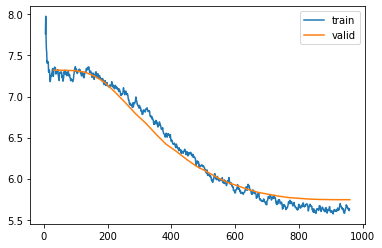

In [ ]:
learn.recorder.plot_loss()

In [ ]:
df['reviews.text'][0]

'our experience at rancho valencia was absolutely perfect from beginning to end!!!! we felt special and very happy during our stayed. i would come back in a heart beat!!!'

In [ ]:
outputs = learn.blurr_generate(df['reviews.text'][0], early_stopping=False, num_return_sequences=1)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
Our stay at rancho valencia was absolutely perfect from beginning to end!!!! we felt special and very happy during our stayed. i would come back in a heart beat!!! we would do it all over again in a heartbeat. we would love to go back again.



In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(6.9214, device='cuda:0', grad_fn=<NllLossBackward0>),
 torch.Size([3, 15, 50264]))

In [ ]:
learn.show_results(learner=learn, max_n=10)


,text,target,prediction
0,"my sister came into town so we decided to go to the national harbor for a night. checking in, the hotel staff was very pleasant. parking is in a garage behind the hotel, for 18. our room was clean with nice views. the bed was very comfortable. we were able to walk comfortably to the harbor and sightsee. there are also restaurants and bars within walking distance. breakfast was great, with canadian bacon and sausage patty meat options. there was also a waffle station, eggs, potatoes, fruit, yogurt, cereal, muffins, and other pastries. checkout was a breeze, and the front desk staff again, was very pleasant. i very much enjoyed my stay and i will definitely return!",awesome stay,"breakfast was great, with canadian bacon and sausage patty meat options."
1,bad: the hotel is next to train tracks so there is some noise from that pretty often but it's really not so bad and you kind of have to expect some noise when you're staying at a hotel that's literally in the middle of the city. good: very tech friendly as the hotel has its own smartphone app which allows you to order room service and control the thermostat among other things. the staff is very friendly and accommodating. the room is designed very well. also the price of the mini bar items are actually reasonable.,beautiful hotel and great value,very tech friendly as the hotel has its own smartphone app. the staff is very friendly and accommodating.
2,"excellent experience. due to a mix-up on my part with the online travel service it was set up as a king rather than two queen beds, for two guys. i immediately called at the time and hampton said they would make a note that a room with two queens was needed. when i got there, they didn't have a 2-queen room so they put me up in another king room (and my buddy stayed in the original room) at no additional expense, and i moved to a 2-queen room the next day. that is awesome, customer-oriented service.",excellent!,excellent experience.


In [ ]:
from matplotlib import pyplot 
pyplot.plot(learn.['train_loss'], label='train') 
pyplot.plot(learn['valid_loss'], label='test') 
pyplot.legend() 
pyplot.show()


SyntaxError: ignored

In [ ]:
#learn.unfreeze()
#learn.fit_one_cycle(10, lr_max=7e-5, cbs=fit_cbs)

In [ ]:
learn.lr_find()